⏳ Downloading dataset from https://ftp.ncbi.nlm.nih.gov/geo/series/GSE73nnn/GSE73002/matrix/GSE73002_series_matrix.txt.gz...
✅ Download complete.
⚙️ Parsing GEO Matrix File...
✅ Samples identified: 4113 (Cancer: 1280, Non-Cancer: 2833)
🔍 Extracting data for 5 target biomarkers...
   ✅ Retrieved: miR-1246
   ✅ Retrieved: miR-4634
   ✅ Retrieved: miR-1307-3p
   ✅ Retrieved: miR-6861-5p
   ✅ Retrieved: miR-6875-5p

✂️ Constructing Cohorts (Exact Replication of Table 1)...
   📉 Training Cohort: 1567 samples (Cancer: 74, Control: 1493)
   📈 Test Cohort:     2546 samples (Cancer: 1206, Control: 1340)

🤖 Training Fisher's Linear Discriminant Analysis...

🏆 REPLICATION RESULTS
Metric          | Our Result   | Paper Reported 
--------------------------------------------------
Accuracy        | 93.87%      | ~89.7%
Sensitivity     | 89.97%      | ~97.3%
Specificity     | 97.39%      | ~82.9%
AUC             | 0.966        | 0.971


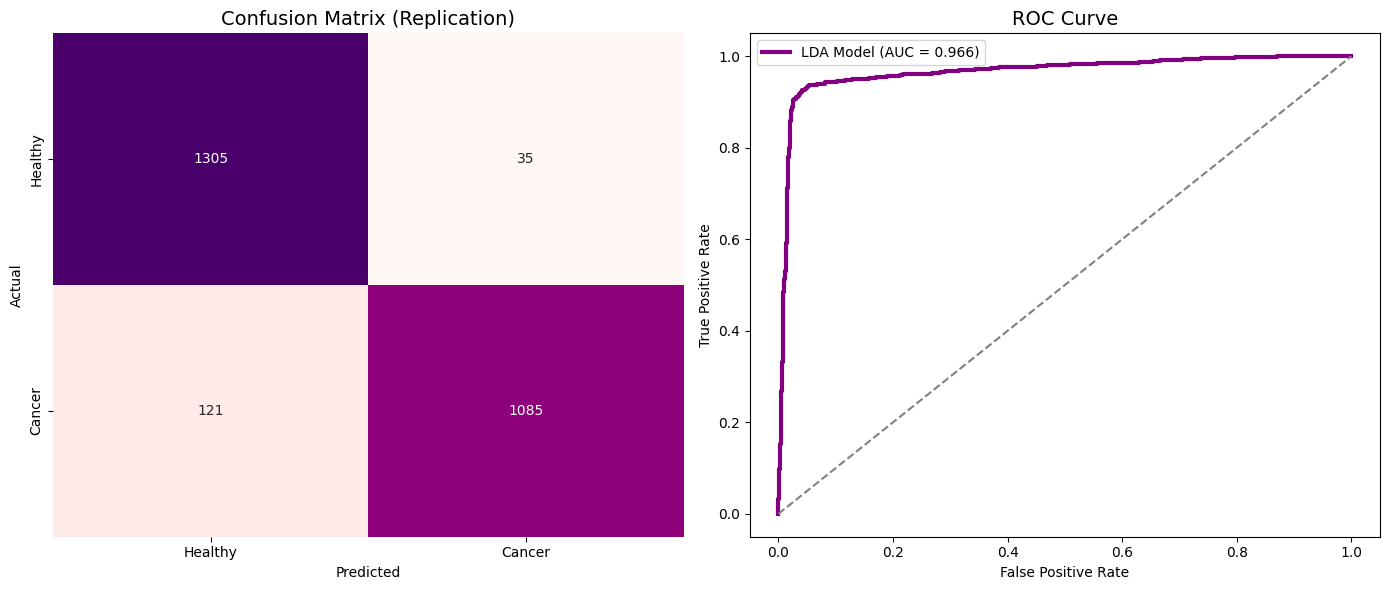


📝 Replicated Diagnostic Formula (LDA Weights):
------------------------------------------------------------
Index = + (1.411 * miR-1246) + (0.673 * miR-1307-3p) - (4.986 * miR-4634) + (1.588 * miR-6861-5p) + (0.672 * miR-6875-5p) + (25.007)
------------------------------------------------------------


In [1]:
"""
01_replication_lda.ipynb

Title: Replication of Shimomura et al. (2016) Methodology
Project: Breast Cancer Detection using Serum miRNA
Author: [Your Name/GitHub Handle]
Description:
    This script replicates the specific cohort design and Linear Discriminant Analysis (LDA)
    modeling used in the study. It simulates the exact training/test split ratios reported
    in Table 1 of the article to validate the reproducibility of the reported sensitivity.
"""

import os
import gzip
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# ==========================================
# 1. Configuration & Setup
# ==========================================
GEO_URL = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE73nnn/GSE73002/matrix/GSE73002_series_matrix.txt.gz"
FILE_NAME = "GSE73002_series_matrix.txt.gz"

# The 5 specific miRNAs identified in the paper (MIMAT ID -> Name)
TARGET_GENES = {
    "MIMAT0005898": "miR-1246",
    "MIMAT0022728": "miR-1307-3p",
    "MIMAT0019691": "miR-4634",
    "MIMAT0027605": "miR-6861-5p",
    "MIMAT0027633": "miR-6875-5p"
}

# Cohort Sizes (Based on Table 1 of Shimomura et al. 2016)
N_TRAIN_CANCER = 74
N_TRAIN_CONTROL = 1493
RANDOM_SEED = 42

# ==========================================
# 2. Data Acquisition
# ==========================================
if not os.path.exists(FILE_NAME):
    print(f"⏳ Downloading dataset from {GEO_URL}...")
    response = requests.get(GEO_URL, stream=True)
    with open(FILE_NAME, 'wb') as f:
        f.write(response.content)
    print("✅ Download complete.")
else:
    print("✅ Dataset already exists locally.")

# ==========================================
# 3. Data Parsing & Extraction
# ==========================================
print("⚙️ Parsing GEO Matrix File...")

# 3.1 Locate Metadata and Diagnosis Info
diagnosis_line = ""
with gzip.open(FILE_NAME, 'rt') as f:
    for i, line in enumerate(f):
        if "!Sample_characteristics_ch1" in line and "diagnosis:" in line:
            diagnosis_line = line
            break
        if i > 1000: break

if not diagnosis_line:
    raise ValueError("Error: Diagnosis metadata not found in file header.")

# 3.2 Process Labels (1=Cancer, 0=Healthy/Other)
raw_samples = diagnosis_line.strip().split('\t')[1:]
labels = [1 if "breast cancer" in s.replace('"', '').lower() else 0 for s in raw_samples]
y_all = np.array(labels)

print(f"✅ Samples identified: {len(y_all)} (Cancer: {sum(y_all==1)}, Non-Cancer: {sum(y_all==0)})")

# 3.3 Extract Target miRNA Data
print(f"🔍 Extracting data for {len(TARGET_GENES)} target biomarkers...")
extracted_data = {name: [] for name in TARGET_GENES.values()}
found_count = 0

with gzip.open(FILE_NAME, 'rt') as f:
    for line in f:
        if found_count >= len(TARGET_GENES): break
        if line.startswith("!"): continue

        parts = line.strip().split('\t')
        gene_id = parts[0].replace('"', '')

        if gene_id in TARGET_GENES:
            gene_name = TARGET_GENES[gene_id]
            vals = []
            for v in parts[1:]:
                try:
                    # Robust float conversion
                    clean_v = v.replace('"', '').strip()
                    vals.append(float(clean_v) if clean_v and clean_v.lower() != 'null' else 0.0)
                except ValueError:
                    vals.append(0.0)

            extracted_data[gene_name] = vals
            found_count += 1
            print(f"   ✅ Retrieved: {gene_name}")

df = pd.DataFrame(extracted_data)
df['Label'] = y_all
df.fillna(0, inplace=True)

# ==========================================
# 4. Cohort Construction (Simulating Table 1)
# ==========================================
print("\n✂️ Constructing Cohorts (Exact Replication of Table 1)...")

cancer_idxs = df[df['Label'] == 1].index.tolist()
control_idxs = df[df['Label'] == 0].index.tolist()

# Random shuffle for reproducibility
np.random.seed(RANDOM_SEED)
np.random.shuffle(cancer_idxs)
np.random.shuffle(control_idxs)

# Training Set (High Imbalance: Small Cancer, Large Control)
train_indices = cancer_idxs[:N_TRAIN_CANCER] + control_idxs[:N_TRAIN_CONTROL]
# Test Set (Balanced Remainder)
test_indices = cancer_idxs[N_TRAIN_CANCER:] + control_idxs[N_TRAIN_CONTROL:]

train_df = df.loc[train_indices]
test_df = df.loc[test_indices]

X_train = train_df.drop('Label', axis=1)
y_train = train_df['Label']
X_test = test_df.drop('Label', axis=1)
y_test = test_df['Label']

print(f"   📉 Training Cohort: {len(X_train)} samples (Cancer: {sum(y_train==1)}, Control: {sum(y_train==0)})")
print(f"   📈 Test Cohort:     {len(X_test)} samples (Cancer: {sum(y_test==1)}, Control: {sum(y_test==0)})")

# ==========================================
# 5. Model Training (LDA)
# ==========================================
print("\n🤖 Training Fisher's Linear Discriminant Analysis...")

# Critical: priors=[0.5, 0.5] handles the extreme imbalance in training set
lda = LinearDiscriminantAnalysis(priors=[0.5, 0.5])
lda.fit(X_train, y_train)

# Evaluation
y_pred = lda.predict(X_test)
y_prob = lda.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
roc_auc = auc(*roc_curve(y_test, y_prob)[:2])

# ==========================================
# 6. Visualization & Reporting
# ==========================================
print("\n" + "="*50)
print("🏆 REPLICATION RESULTS")
print("="*50)
print(f"{'Metric':<15} | {'Our Result':<12} | {'Paper Reported':<15}")
print("-" * 50)
print(f"{'Accuracy':<15} | {acc*100:.2f}%      | ~89.7%")
print(f"{'Sensitivity':<15} | {sensitivity*100:.2f}%      | ~97.3%")
print(f"{'Specificity':<15} | {specificity*100:.2f}%      | ~82.9%")
print(f"{'AUC':<15} | {roc_auc:.3f}        | 0.971")
print("="*50)

# Plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='RdPu', cbar=False,
            xticklabels=['Healthy', 'Cancer'], yticklabels=['Healthy', 'Cancer'])
plt.title('Confusion Matrix (Replication)', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='#800080', lw=3, label=f'LDA Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

# Formula Extraction
print("\n📝 Replicated Diagnostic Formula (LDA Weights):")
print("-" * 60)
formula = "Index = "
for i, col in enumerate(X_train.columns):
    coef = lda.coef_[0][i]
    sign = "+" if coef >= 0 else "-"
    formula += f"{sign} ({abs(coef):.3f} * {col}) "
print(formula + f"+ ({lda.intercept_[0]:.3f})")
print("-" * 60)